In [ ]:
pip install pandas-datareader

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas_datareader import data as pdr
import datetime as dt

import yfinance as yf
yf.pdr_override()

#Neural Network는 0~1 혹은 -1~1 로 데이터를 scaling 하는 것이 좋다
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential

crypto_currency = 'BTC'
against_currency = 'USD'

start = dt.datetime(2016, 1, 1)
end = dt.datetime.now()

data = pdr.get_data_yahoo('BTC-USD', start, end)

print(data.head())

[*********************100%%**********************]  1 of 1 completed

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2016-01-01  430.721008  436.246002  427.515015  434.334015  434.334015   
2016-01-02  434.622009  436.062012  431.869995  433.437988  433.437988   
2016-01-03  433.578003  433.743011  424.705994  430.010986  430.010986   
2016-01-04  430.061005  434.516998  429.084015  433.091003  433.091003   
2016-01-05  433.069000  434.182007  429.675995  431.959991  431.959991   

              Volume  
Date                  
2016-01-01  36278900  
2016-01-02  30096600  
2016-01-03  39633800  
2016-01-04  38477500  
2016-01-05  34522600  


In [ ]:
#특정 60일을 활용해서 train할 것인데, 이걸 상승장? 매크로가 유사한 상황으로 학습 시켜보자

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))

prediction_days = 60
future_day = 30

x_train, y_train = [], []

for x in range(prediction_days, len(scaled_data)-future_day):
    #x를 제외한 날짜
    x_train.append(scaled_data[x-prediction_days:x, 0])
    #x날짜
    y_train.append(scaled_data[x+future_day, 0])

#numpy array로 변환
x_train, y_train = np.array(x_train), np.array(y_train)

#형태변환, additional dimention 을 더해준다, shape[0] 원래 x축, shape[1] 원래 y축, 1로 새로운 3차원으로 만들어줌. 3차원의 길이가 1 이다.
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [ ]:
#1일차 2일차 등 sequential하다. 시계열 데이터?
model = Sequential()

#LSTM은 Sequential 데이터의 중요한 요소들을 다시 layer에 넣어준다
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))

model.add(Dropout(0.2))
#dropout은 overfitting 방지용

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50))
model.add(Dropout(0.2))

model.add(Dense(units=1))


model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=25, batch_size=32)

Epoch 1/25
91/91 [==============================] - 14s 93ms/step - loss: 0.0117
Epoch 2/25
91/91 [==============================] - 7s 81ms/step - loss: 0.0084
Epoch 3/25
91/91 [==============================] - 8s 92ms/step - loss: 0.0069
Epoch 4/25
91/91 [==============================] - 8s 83ms/step - loss: 0.0077
Epoch 5/25
91/91 [==============================] - 8s 90ms/step - loss: 0.0069
Epoch 6/25
91/91 [==============================] - 8s 93ms/step - loss: 0.0066
Epoch 7/25
91/91 [==============================] - 7s 81ms/step - loss: 0.0064
Epoch 8/25
91/91 [==============================] - 8s 93ms/step - loss: 0.0062
Epoch 9/25
91/91 [==============================] - 8s 93ms/step - loss: 0.0057
Epoch 10/25
91/91 [==============================] - 8s 83ms/step - loss: 0.0056
Epoch 11/25
91/91 [==============================] - 9s 94ms/step - loss: 0.0053
Epoch 12/25
91/91 [==============================] - 8s 91ms/step - loss: 0.0054
Epoch 13/25
91/91 [=================

In [ ]:
test_start= dt.datetime(2020,9,1)
test_end = dt.datetime(2021, 5, 28)

test_data = pdr.get_data_yahoo('BTC-USD', test_start, test_end)

#종가를 test로 가져온다
actual_prices = test_data['Close'].values

#total에 위의 test도 가져온다
total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)

print(total_dataset.head())
print(total_dataset.shape)

model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
print(model_inputs.shape)

model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.fit_transform(model_inputs)

x_test = []

for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

prediction_prices = model.predict(x_test)

#inverse scale them

prediction_prices = scaler.inverse_transform(prediction_prices)

print(prediction_prices)

[*********************100%%**********************]  1 of 1 completed

Date
2016-01-01    434.334015
2016-01-02    433.437988
2016-01-03    430.010986
2016-01-04    433.091003
2016-01-05    431.959991
Name: Close, dtype: float64
(3263,)
(329,)
1/9 [==>...........................] - ETA: 0s

9/9 [==============================] - 0s 39ms/step
[[63401.6   ]
 [59876.88  ]
 [55171.51  ]
 [50180.85  ]
 [45345.58  ]
 [40850.664 ]
 [36767.    ]
 [33100.312 ]
 [29816.727 ]
 [26884.879 ]
 [24275.36  ]
 [21955.783 ]
 [19886.521 ]
 [18015.992 ]
 [16317.985 ]
 [14765.175 ]
 [13341.101 ]
 [12028.931 ]
 [10820.067 ]
 [ 9726.438 ]
 [ 8752.156 ]
 [ 7881.086 ]
 [ 7129.9814]
 [ 6504.9614]
 [ 6056.494 ]
 [ 5803.551 ]
 [ 5750.1455]
 [ 5881.8506]
 [ 6169.6733]
 [ 6580.529 ]
 [ 7073.498 ]
 [ 7603.728 ]
 [ 8122.261 ]
 [ 8612.987 ]
 [ 9057.493 ]
 [ 9459.753 ]
 [ 9804.709 ]
 [10095.587 ]
 [10348.714 ]
 [10581.557 ]
 [10808.728 ]
 [11033.566 ]
 [11257.774 ]
 [11462.673 ]
 [11634.07  ]
 [11768.721 ]
 [11855.111 ]
 [11896.169 ]
 [11910.835 ]
 [11925.657 ]
 [11960.861 ]
 [12074.035 ]
 [12272.307 ]
 [12526.478 ]
 [12808.087 ]
 [13080.294 ]
 [13318.827 ]
 [13546.679 ]
 [13737.263 ]
 [13888.045 ]
 [14005.433 ]
 [14107.588 ]
 [14194.938 ]
 [14253.037 ]
 [14305.084 ]
 [14369.855 ]
 [14542.375 ]
 [14823.58

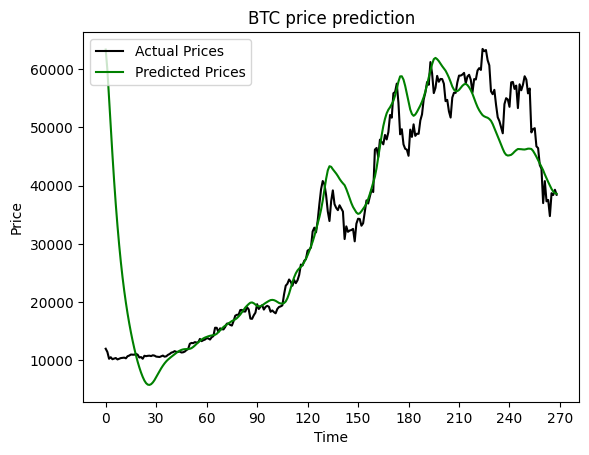

In [ ]:
plt.plot(actual_prices, color='black', label='Actual Prices')
plt.plot(prediction_prices, color = 'green', label = 'Predicted Prices')
plt.title(f'{crypto_currency} price prediction')
plt.xlabel('Time')
plt.xticks([i for i in range(0,300,30)])
plt.ylabel('Price')
plt.legend(loc='upper left')
plt.show()

#걍 60일 보고 하루 찍고, 60일 보고 하루 찍은 거임
#이전 prediction을 보고 그 다음 날을 찍게 만들어야 됨

#걍 past performance를 본 것이다

이제 실제로 prediction해보자

In [ ]:
real_data = [model_inputs[len(model_inputs) + 1 - prediction_days:len(model_inputs)+1, 0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))

In [ ]:
prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)
print(prediction)

1/1 [==============================] - 0s 72ms/step
[[71545.75]]


비슷한 매크로 상황이었을 때를 가정하고, 일단위로 60일 대신 30분 혹은 1시간 단위로 학습 시키고, 30시간 뒤 등을 가정하고 그 가격보다 낮을 경우 매입 하는 등을 시도할 수 있다.

Backtesting을 해보자